# Building Operators in PyLops V2: What's New? 

**Author: C. Costa, PyLops Dev Team**

The aim of this second tutorial is to introduce you to some features in our latest creation (still in the making): **PyLops V2**

As any new Major version, there will be breaking changes! 

Nevetheless, this is the very first time since the initial creation of PyLops that we decided to sit back and revisit some the early design choices. We hope the benefit introduced by such changes outweights the pain of making a few changes to your codes.

In the following we want to give you a taste of some new features and highlight along the way if (and how) these have required breaking changes.

For more details on how to quickly migrate your PyLops v1.x codes into PyLops v2.x codes please refer to this [document](https://github.com/PyLops/pylops/blob/dev/MIGRATION_V1_V2.md).

## Useful links

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2022
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Let's Get Shifty

To get started, let's suppose we want to implement a simple shift operator.
Stating the problem more descriptively, we want an operator that

1. Depends on a (possibly fractional) parameter `shift`
2. Can be applied to a vector along a certain given `axis`.
3. A positive `shift` should shift the vector to the right; a negative `shift` to the left.
4. The shift is not circular, that is, when shifting to the right, the last samples will not appear in the beginning of the array.

PyLops already features a much fancier [Shift operator](https://pylops.readthedocs.io/en/stable/api/generated/pylops.signalprocessing.Shift.html) that works in the Fourier domain, but it is circular.
Numpy offers the `roll` function, but on its own, it does not support fractional shifts and is also circular.
Note that both of these options could be made non-circular by padding, but for now we're gonna "roll" our own! 😉


---------------------

Before we jump on creating the operator, let's code a function to do the shift.
After we have the workhorse, it will be easier to write the boilerplate code required for the `LinearOperator`.

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pylops

from typing import Tuple

plt.style.use('tableau-colorblind10')
np.random.seed(0)

We're going to start with an integer-based shifting function, which we will exploit later to convert into a fractional shifter. We want this function to be pretty fast, so we're going to pad the original array and pad it with the correct number of zeros.

<img src="figs/crop_pad_concatenate.png" width="300" align="center">


In [2]:
# Original array
x = 1.0 + np.arange(9)

print("Original array:", x)

# Tests for our (integer) shifting method
shift = 3
shifted = np.concatenate((np.zeros(shift), x[:-shift]))
print("Positive shift:", shifted)

shift = -3
shifted = np.concatenate((x[-shift:], np.zeros(-shift)))
print("Negative shift:", shifted)

shift = 0
shifted = np.concatenate((x[-shift:], np.zeros(-shift)))
print("No shift      :", shifted)

shift = 12
shifted = np.concatenate((np.zeros(shift), x[:-shift]))  # Oops!!
print("Big pos. shift:", shifted)

shift = -12
shifted = np.concatenate((x[-shift:], np.zeros(-shift)))  # Oops!!
print("Big neg. shift:", shifted)

Original array: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Positive shift: [0. 0. 0. 1. 2. 3. 4. 5. 6.]
Negative shift: [4. 5. 6. 7. 8. 9. 0. 0. 0.]
No shift      : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Big pos. shift: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Big neg. shift: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now that we know what to do, we can package it into a simple 1D function.

In [3]:
def shift1d(x: npt.NDArray, shift: int):
    shift = max(
        min(shift, len(x)), -len(x)
    )  # Fix the oops: ensure shift between -len(x) and len(x)]
    if shift > 0:
        return np.concatenate((np.zeros(shift), x[:-shift]))
    else:
        return np.concatenate((x[-shift:], np.zeros(-shift)))


for shift in [3, -3, 0, 12, -12]:  # This should be probably be a unit test...
    print(shift1d(x, shift))

[0. 0. 0. 1. 2. 3. 4. 5. 6.]
[4. 5. 6. 7. 8. 9. 0. 0. 0.]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


Looking good! Now we need to make sure this works for N-dimensional arrays.
The trick here is to rely on swapaxes (it returns a view, cheap!) and the ellipsis notation.
Let's have a go:

In [4]:
x_3d = np.tile(x, (2, 3, 1))
print(x_3d.shape)
x_3d

(2, 3, 9)


array([[[1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [1., 2., 3., 4., 5., 6., 7., 8., 9.]],

       [[1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [1., 2., 3., 4., 5., 6., 7., 8., 9.]]])

In [5]:
shift = 4
axis = -1  # Last axis

x_3d_tmp = np.swapaxes(x_3d, axis, -1)  # It's view, chill
x_3d_crop = x_3d_tmp[..., :-shift]  # Same as x_3d_tmp[:, :, :-shift] for 3D arrays

pad_shape = list(x_3d.shape)
pad_shape[-1] = abs(shift)
pad = np.zeros(pad_shape)

shifted = np.concatenate((pad, x_3d_crop), axis=-1)  # Beware, default is axis=0!
shifted

array([[[0., 0., 0., 0., 1., 2., 3., 4., 5.],
        [0., 0., 0., 0., 1., 2., 3., 4., 5.],
        [0., 0., 0., 0., 1., 2., 3., 4., 5.]],

       [[0., 0., 0., 0., 1., 2., 3., 4., 5.],
        [0., 0., 0., 0., 1., 2., 3., 4., 5.],
        [0., 0., 0., 0., 1., 2., 3., 4., 5.]]])

Packaging it:

In [6]:
def shiftnd(x: npt.NDArray, shift: int, axis: int = -1):
    if shift > x.shape[axis] or shift < -x.shape[axis]:
        return np.zeros_like(x)
    x = np.swapaxes(x, axis, -1)  # Relax, original x is unchanged
    pad = np.zeros((*x.shape[:-1], abs(shift)))
    if shift > 0:
        out = np.concatenate((pad, x[..., :-shift]), axis=-1)
    else:
        out = np.concatenate((x[..., -shift:], pad), axis=-1)
    return np.swapaxes(out, axis, -1)


for shift in [1, 0, -2]:  # This should be definitely be a unit test...
    print(f"Shift = {shift}")
    print("Axis = 0 :")
    print(shiftnd(x_3d, shift, axis=0))
    print("Axis = -1:")
    print(shiftnd(x_3d, shift, axis=-1))
    print()

Shift = 1
Axis = 0 :
[[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]]]
Axis = -1:
[[[0. 1. 2. 3. 4. 5. 6. 7. 8.]
  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
  [0. 1. 2. 3. 4. 5. 6. 7. 8.]]

 [[0. 1. 2. 3. 4. 5. 6. 7. 8.]
  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
  [0. 1. 2. 3. 4. 5. 6. 7. 8.]]]

Shift = 0
Axis = 0 :
[[[1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]]

 [[1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]]]
Axis = -1:
[[[1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]]

 [[1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  [1. 2. 3. 4. 5. 6. 7. 8. 9.]]]

Shift = -2
Axis = 0 :
[[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.

We're almost done. We figured out how to shift by an integer amount in either direction. To shift a fractional amount, we will linearly interpolate the result of shifting by the floor and ceil of the fractional shift! Let $L_\delta$ represent the fractional shift operator by $\delta$ shift, and let $S_\delta$ represent the integer shift operator by $\delta$. Let $w = \delta - ⌊\delta⌋$ represent the fractional amount of the shift.

$$
L_\delta x \equiv (1 - w) S_{⌊\delta⌋}x + w S_{⌈\delta⌉}
$$

In [7]:
def shiftnd_linear(x: npt.NDArray, shift: float, axis: int = -1):
    shift_floor = int(np.floor(shift))
    w = shift - shift_floor
    return (1 - w) * shiftnd(x, shift_floor, axis) + w * shiftnd(
        x, shift_floor + 1, axis
    )


print(x)
print(shiftnd_linear(x, 2.1))
print(shiftnd_linear(x, 8))
print(shiftnd_linear(x, 8.9))
print(shiftnd_linear(x, 9))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0.  0.  0.9 1.9 2.9 3.9 4.9 5.9 6.9]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.  0.  0.  0.  0.  0.  0.  0.  0.1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


## A Simple  `LinearOperator`

In this section we will take what we learned about shifting and package that in a `LinearOperator` class.
What follows is a fairly generic template that can serve as a basis for implementing a wide array of linear operators.

In [8]:
class LinearShift(pylops.LinearOperator):
    """LinearShift shifts an N-dimensional array by a single real value along a given axis.

    Since we are responsible coders, this is the entirety of our very long
    and detailed documentation for this class. At least we're annotating...
    """

    def __init__(
        self,
        shift: float,
        dims: Tuple[int, ...],
        axis: int = -1,
        dtype: npt.DTypeLike = np.float32,
        name: str = "L",  # Not required but good practice since v2.0.0
    ):
        # We need to store these variables for computing the shifts
        self.shift = shift
        self.axis = axis

        # Every operator needs a dtype and a shape. Since v2.0.0, we can instead give
        # dims (model shape) *and* dimsd (data shape). `self.shape` is automatically
        # inferred as (np.prod(dimsd), np.prod(dims)).
        # Calling `super()` will also populate `self.clinear` (defaults to True) and
        # `self.explicit` (defaults to False). See the latest documentation:
        # https://pylops.readthedocs.io/en/latest/api/generated/pylops.LinearOperator.html
        super().__init__(dtype=dtype, dims=dims, dimsd=dims, name=name)

    def _matvec(self, x: npt.NDArray):
        x = x.reshape(self.dims)
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        y = y.ravel()
        return y

 In the new version, we use the name of the operator to `describe` it: 

In [9]:
from pylops.utils.describe import describe


LOp = LinearShift(0.5, dims=x_3d.shape)
describe(LOp)

L

where: {'L': 'LinearShift'}


In [10]:
# Taking it for a spin
shifted = (LOp @ x_3d.ravel()).reshape(LOp.dimsd)
shifted

array([[[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]],

       [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
        [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]]])

Great! But what if we try the following?

In [11]:
try:
    LOp.T @ shifted.ravel()
except AttributeError:
    print("Oops!")

Oops!


This is because we need to define both the forward and the adjoint. The good news for us is that the adjoint should just be a negative shift.

In [12]:
class LinearShift(pylops.LinearOperator):
    """LinearShift shifts an N-dimensional array by a single real value along a given axis.

    Since we are responsible coders, this is the entirety of our very long
    and detailed documentation for this class. At least we're annotating...
    """

    def __init__(
        self,
        shift: float,
        dims: Tuple[int, ...],
        axis: int = -1,
        dtype: npt.DTypeLike = np.float32,
        name: str = "L",  # Not required but good practice since v2.0.0
    ):
        # We need to store these variables for computing the shifts
        self.shift = shift
        self.axis = axis

        # Every operator needs a dtype and a shape. Since v2.0.0, we can instead give
        # dims (model shape) *and* dimsd (data shape). `self.shape` is automatically
        # calculated as (np.prod(dimsd), np.prod(dims)).
        # Calling `super()` will also populate `self.clinear` (defaults to True) and
        # `self.explicit` (defaults to False). See the latest documentation:
        # https://pylops.readthedocs.io/en/latest/api/generated/pylops.LinearOperator.html
        super().__init__(dtype=dtype, dims=dims, dimsd=dims, name=name)

    def _matvec(self, x: npt.NDArray):
        x = x.reshape(self.dims)
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        y = y.ravel()
        return y

    def _rmatvec(self, y: npt.NDArray):
        y = y.reshape(self.dimsd)
        #                         negative shift!
        x = shiftnd_linear(y, shift=-self.shift, axis=self.axis)
        x = x.ravel()
        return x


# Taking it for a spin
LOp = LinearShift(0.5, dims=x_3d.shape)
shifted_back = (LOp.T @ shifted.ravel()).reshape(LOp.dimsd)
shifted_back

array([[[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]],

       [[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]]])

Are we done now? Nope! We need to ensure that the operations in `_matvec` and `_rmatvec` are actually transposes of each other. To do so, we can use the [`dottest`](https://pylops.readthedocs.io/en/latest/api/generated/pylops.utils.dottest.html) utility function.

In [13]:
from pylops.utils import dottest

dottest(LOp, verb=True, raiseerror=True)

Dot test passed, v^H(Opu)=-1.8444506555541245 - u^H(Op^Hv)=-1.844450655554124


True

Since it passes the dot test, we're done!

Interestingly enough, we see saw that applying the adjoint in succession to the forward is not an inverse

In [14]:
describe(LOp.T @ LOp)

L.T*L

where: {'L': 'LinearShift'}


In [15]:
shifted_back_adj = (LOp.T @ LOp @ x_3d.ravel()).reshape(x_3d.shape)
np.allclose(shifted_back_adj, x_3d)

False

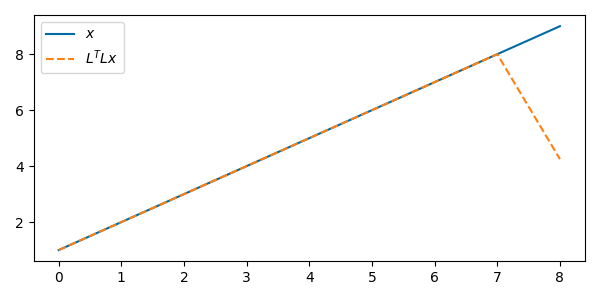

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_3d[0, 0, :], label=r"$x$")
ax.plot(shifted_back_adj[0, 0, :], "--", label="$L^T L x$")
ax.legend(loc=2)
fig.tight_layout()

Of course, when we have values at the edges and shift them out of the array we lose them. So in a way, the operator will never have a true inverse.
But we can use solvers to aid us in filling this null space.
In this case, the least-squares solution we get is the following:

In [17]:
shifted_back_lsqr = (LOp / shifted.ravel()).reshape(LOp.dimsd)

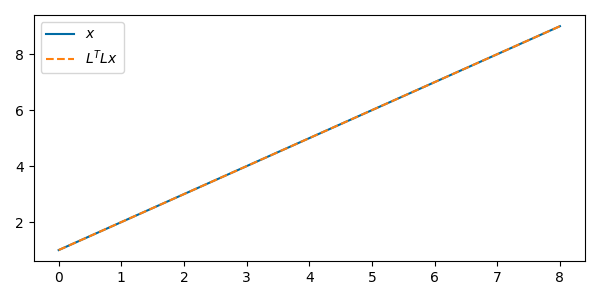

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_3d[0, 0, :], label=r"$x$")
ax.plot(shifted_back_lsqr[0, 0, :], "--", label="$L^T L x$")
ax.legend(loc=2)
fig.tight_layout()

Pretty good, huh?

Ok, but now let's try a harder one.

In [19]:
dims = (20,)

LOp1D = LinearShift(5.9, dims=dims)

x_noise = np.random.uniform(low=1, high=10, size=dims)  # Sample away from 0-mean

shifted_noise = LOp1D @ x_noise

shifted_back_noise_adj = LOp1D.T @ LOp1D @ x_noise

shifted_back_noise_lsqr = LOp1D / shifted_noise

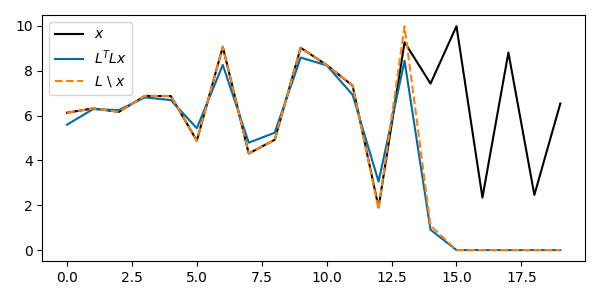

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_noise, "k", label=r"$x$")
ax.plot(shifted_back_noise_adj, label=r"$L^T L x$")
ax.plot(shifted_back_noise_lsqr, "--", label="$L$ \ $x$")
ax.legend(loc=2)
fig.tight_layout()

Here we can see that
1. Both the least-squares solution ($L\backslash b$) and the adjoint ($L^T b$) sets unknown values to be zero (or very close to zero)
2. The adjoint solution does not recover the exact values where we did not lose information. This does not happen to the least-squares solution.
   
The first observation can be explained by the nature of adjoint operator, which pads elements with zero. The least-squares solution does not deviate substantially from this in the null space. Importantly, however, the least-squares solution recovers the signal exactly outside of the null space.

In PyLops, when we call the division operator, we are actually calling an iterative least-squares method — the favored approach when you do not have matrices. There are many other solvers available, some of them showcased in the [previous presentation](https://github.com/PyLops/pylops_transform2022/blob/main/Decon.ipynb). Find more about them here: https://pylops.readthedocs.io/en/latest/tutorials/solvers.html


For this small operator, we can compute the matrix and use a dense solver to obtain a solution. In large problems, we would not have this choice!

In [21]:
from scipy.sparse.linalg import lsqr

L1D = LOp1D.todense()

shifted_back_noise_dense, *_ = np.linalg.lstsq(L1D, shifted_noise, rcond=None)

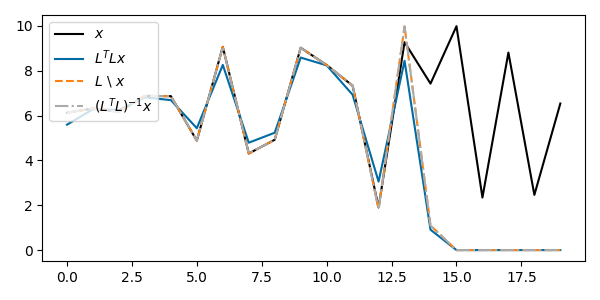

In [22]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_noise, "k", label=r"$x$")
ax.plot(shifted_back_noise_adj, label=r"$L^T L x$")
ax.plot(shifted_back_noise_lsqr, "--", label="$L$ \ $x$")
ax.plot(shifted_back_noise_dense, "-.", label="$(L^T L)^{-1} x$")
ax.legend(loc=2)
fig.tight_layout()

## Reshape/Ravel/Reshape/Ravel/...

One of the biggest pain points for me when using PyLops often was the reshape/ravel combo that pollutes your code. In PyLops 2.0, we have introduced some changes to alleviate that. Some of these are on the user side:

In [23]:
y = LOp @ x_3d
y.shape

(2, 3, 9)

In version 1.x, this code would error requiring always `x_3d.ravel()` as input, and always outputting a flat array. This is what we were doing in this tutorial so far.

The magic 🪄 here is revamped `LinearOperator` class which understands model dimensions (`LOp.dims`) and data dimensions (`LOp.dimsd`). So whereas it still works with flattened arrays, it is now smart enough to reshape internally when needed.

Moreover, it can also "propagate" dims/dimsd across multiple operators, as well as apply to matrices.
Here are some examples:

In [24]:
y = LOp.T @ LOp @ x_3d
print(y.shape)
y

(2, 3, 9)


array([[[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]],

       [[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]]])

In [25]:
X_3d = np.concatenate((x_3d[..., np.newaxis], x_3d[..., np.newaxis]), axis=-1)
X_3d.shape

(2, 3, 9, 2)

In [26]:
y = LOp.T @ LOp @ X_3d
y.shape

(2, 3, 9, 2)

The class needs no change, as long as it has a nontrivial `dims`/`dimsd`, it will work out of the box. We also included some goodies when implementing new operators. The following pattern is very common:

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        y = kernel_which_operates_on_reshaped(x)
        y = y.ravel()
```

In fact, the following pattern is even more common:

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        x = x.swapaxes(self.axis, -1)
        y = kernel_which_operates_on_reshaped(x)
        y.swapaxes(self.axis, -1)
        y = y.ravel()
```

The swapaxes is often used so that we can always assume that the axis on which to apply an operation is always the last one.
This creates allows us to use the `ellipsis` operator in a smart way: we always operate on `x[..., i]`, instead of having to construct indexers.
Previously, we used to do thing like this 🤢:

```python
i_ndim = [ slice(None) ] * len(self.dims)
i_ndim[self.axis] = i
x[i_ndim]
```


Swapaxes is also super cheap since it returns a view of the array.

Using our new `reshaped` decorator, we can simplify our LinearShift functions like this

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        y = y.ravel()
        return y
```

to this:
    
```python
    from pylops.utils.decorators import reshaped
                     ⋮
    @reshaped
    def _matvec(self, x: npt.NDArray[np.float32]):
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        return y
```

or this

```python
    from pylops.utils.decorators import reshaped
                     ⋮
    @reshaped(swapaxis=True)
    def _matvec(self, x: npt.NDArray[np.float32]):
        y = shiftnd_linear(x, shift=self.shift, axis=-1)
        return y
```



To finish this tutorial, let's see the full standalone `LinearShift` operator with some extra goodies.

In [27]:
import logging
import pylops
from pylops.utils.decorators import reshaped

try:
    from numba import jit

    NUMBA_AVAILABLE = True
except ImportError:
    NUMBA_AVAILABLE = False


class LinearShift(pylops.LinearOperator):
    """LinearShift shifts an N-dimensional array by a single real value along a given axis.

    Since we are responsible coders, this is the entirety of our very long
    and detailed documentation for this class. At least we're annotating...
    """

    def __init__(
        self,
        shift: float,
        dims: Tuple[int, ...],
        axis: int = -1,
        dtype: npt.DTypeLike = np.float32,
        name: str = "L",
    ):
        self.shift = shift
        self.axis = axis

        super().__init__(dtype=dtype, dims=dims, dimsd=dims, name=name)

        self._register_shiftnd_linear()

    def _register_shiftnd_linear(self):
        """
        Register the correct method depending on whether Numba
        is available or not.
        """
        def shiftnd(x: npt.NDArray, shift: int):
            if shift > x.shape[-1] or shift < -x.shape[-1]:
                return np.zeros_like(x)
            pad = np.zeros((*x.shape[:-1], abs(shift)))
            if shift > 0:
                out = np.concatenate((pad, x[..., :-shift]), axis=-1)
            else:
                out = np.concatenate((x[..., -shift:], pad), axis=-1)
            return out

        def shiftnd_linear(x: npt.NDArray, shift: float):
            shift_floor = int(np.floor(shift))
            w = shift - shift_floor
            return (1 - w) * shiftnd(x, shift_floor) + w * shiftnd(x, shift_floor + 1)

        if NUMBA_AVAILABLE:
            numba_opts = dict(nopython=True, fastmath=True, nogil=True, parallel=True)
            shiftnd = jit(**numba_opts)(shiftnd) # We must jit all functions used by `shiftnd_linear`t
            shiftnd_linear = jit(**numba_opts)(shiftnd_linear)
        else:
            logging.warning("Numba is OFF!")
        self._shiftnd_linear = shiftnd_linear

    @reshaped(swapaxis=True)
    def _matvec(self, x: npt.NDArray):
        return self._shiftnd_linear(x, shift=self.shift)

    @reshaped(swapaxis=True)
    def _rmatvec(self, y: npt.NDArray):
        return self._shiftnd_linear(y, shift=-self.shift)


# Taking it for a spin
LOp = LinearShift(0.5, dims=x_3d.shape)
LOp.T @ LOp @ x_3d

array([[[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]],

       [[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
        [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]]])